In [ ]:
import numpy
from urllib.request import urlopen
import scipy.optimize
import random
from sklearn import svm
from sklearn import linear_model

def parseDataFromURL(fname):
  for l in urlopen(fname):
    yield eval(l)

def parseData(fname):
  for l in open(fname):
    yield eval(l)

print("Reading data...")
# Download from http://jmcauley.ucsd.edu/cse258/data/amazon/book_descriptions_50000.json
data = list(parseData("data/amazon/book_descriptions_50000.json"))
print("done")

### Naive bayes to determine p(childrens book | mentions wizards and mentions witches) ###

# p(childrens book)
prior = ["Children's Books" in b['categories'] for b in data]
prior = sum(prior) * 1.0 / len(prior)

# p(isn't children's book)
prior_neg = 1 - prior

# p(mentions wizards | is childrens)
p1 = ['wizard' in b['description'] for b in data if "Children's Books" in b['categories']]
p1 = sum(p1) * 1.0 / len(p1)

# p(mentions wizards | isn't childrens)
p1_neg = ['wizard' in b['description'] for b in data if not ("Children's Books" in b['categories'])]
p1_neg = sum(p1_neg) * 1.0 / len(p1_neg)

# p(mentions witches | is childrens)
p2 = ['witch' in b['description'] for b in data if "Children's Books" in b['categories']]
p2 = sum(p2) * 1.0 / len(p2)

# p(mentions witches | isn't childrens)
p2_neg = ['witch' in b['description'] for b in data if not ("Children's Books" in b['categories'])]
p2_neg = sum(p2_neg) * 1.0 / len(p2_neg)

# Prediction

score = prior * p1 * p2
score_neg = prior_neg * p1_neg * p2_neg

# Actual ('non-naive') probability

p = ["Children's Books" in b['categories'] for b in data if 'witch' in b['description'] and 'wizard' in b['description']]
p = sum(p) * 1.0 / len(p)

### Logistic Regression -- "Judging a book by its cover"

print("Reading data...")
# Download from http://jmcauley.ucsd.edu/cse255/data/amazon/book_images_5000.json
data = list(parseData("data/amazon/book_images_5000.json"))
print("done")

X = [b['image_feature'] for b in data]
y = ["Children's Books" in b['categories'] for b in data]

X_train = X[:2500]
y_train = y[:2500]

X_test = X[2500:]
y_test = y[2500:]

# Create a support vector classifier object, with regularization parameter C = 1000
# clf = svm.SVC(C=1000, kernel='linear')
# clf.fit(X_train, y_train)

# train_predictions = clf.predict(X_train)
# test_predictions = clf.predict(X_test)

# Logistic regression classifier
mod = linear_model.LogisticRegression(C=1.0)
mod.fit(X_train, y_train)

train_predictions = mod.predict(X_train)
test_predictions = mod.predict(X_test)


### Diagnostics

# From https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data
f = open("5year.arff", 'r')

# Reading in data
while not '@data' in f.readline():
    pass

dataset = []
for l in f:
    if '?' in l: # Missing entry
        continue
    l = l.split(',')
    values = [1] + [float(x) for x in l]
    values[-1] = values[-1] > 0 # Convert to bool
    dataset.append(values)

# Data setup
X = [d[:-1] for d in dataset]
y = [d[-1] for d in dataset]

# Fit model
mod = linear_model.LogisticRegression(C=1.0)
mod.fit(X,y)

pred = mod.predict(X)

# How many positive predictions?
sum(pred)

# Balanced model
mod = linear_model.LogisticRegression(C=1.0, class_weight='balanced')
mod.fit(X,y)

pred = mod.predict(X)

# How many positive predictions?
sum(pred)

# Train/validation/test splits

# Shuffle the data
Xy = list(zip(X,y))
random.shuffle(Xy)

X = [d[0] for d in Xy]
y = [d[1] for d in Xy]

N = len(y)

Ntrain = 1000
Nvalid = 1000
Ntest = 1031

Xtrain = X[:Ntrain]
Xvalid = X[Ntrain:Ntrain+Nvalid]
Xtest = X[Ntrain+Nvalid:]

ytrain = y[:Ntrain]
yvalid = y[Ntrain:Ntrain+Nvalid]
ytest = y[Ntrain+Nvalid:]

mod.fit(Xtrain, ytrain)

pred = mod.predict(Xtest)

correct = pred == ytest

# True positives, false positives, etc.

TP_ = numpy.logical_and(pred, ytest)
FP_ = numpy.logical_and(pred, numpy.logical_not(ytest))
TN_ = numpy.logical_and(numpy.logical_not(pred), numpy.logical_not(ytest))
FN_ = numpy.logical_and(numpy.logical_not(pred), ytest)

TP = sum(TP_)
FP = sum(FP_)
TN = sum(TN_)
FN = sum(FN_)

# accuracy
sum(correct) / len(correct)
(TP + TN) / (TP + FP + TN + FN)

# BER
1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))

# Ranking

scores = mod.decision_function(Xtest)

scores_labels = list(zip(scores, ytest))
scores_labels.sort(reverse = True)

sortedlabels = [x[1] for x in scores_labels]

# precision / recall
retrieved = sum(pred)
relevant = sum(ytest)
intersection = sum([y and p for y,p in zip(ytest,pred)])

precision = intersection / retrieved
recall = intersection / relevant

# precision at 10
sum(sortedlabels[:10]) / 10

In [24]:
import numpy as np
import pandas as pd
import pprint
import networkx as nx
import matplotlib.pyplot as plt

from urllib.request import urlopen

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
def parseData(fname):
  for l in open(fname):
    yield eval(l)

# Problem 1
# Complete

In [3]:
#Parses the beer data
parsed_beer = list(parseData("beer_50000.json"))

#Uses list comprehension to create lists of all the variables used for the predictive model
cat = [d['beer/style'] for d in parsed_beer]
abv = [d['beer/ABV'] for d in parsed_beer]
aro = [d['review/aroma'] for d in parsed_beer]
appear = [d['review/appearance'] for d in parsed_beer]
pal = [d['review/palate'] for d in parsed_beer]
tas = [d['review/taste'] for d in parsed_beer]
over = [d['review/overall'] for d in parsed_beer]
review_len = [len(d['review/text']) for d in parsed_beer]
stan = [x/max(review_len) for x in review_len]

In [4]:
#Loops through all beer categories to see how many times each category appears
categoryCounts = {}
for d in parsed_beer:
    if d['beer/style'] not in categoryCounts.keys():
        categoryCounts[d['beer/style']] = 0
    categoryCounts[d['beer/style']] += 1

#Stores a dictionary of the indexes for all beer category that have over 1000 appearances
categories = [c for c in categoryCounts if categoryCounts[c] > 1000]
catID = dict(zip(list(categories),range(len(categories))))

In [5]:
#Splits the dataset into 50% train and 50% test
x_train,x_test,y_train,y_test = train_test_split(np.array([cat,aro,appear,pal,tas,over,stan]).T,abv,test_size=0.5)

#Creates empty matrices to allow for the one hot encoding values only
train_matrix = np.zeros((25000,13))
test_matrix = np.zeros((25000,13))

#Converts the y_train and y_test values into binary scores for yes if over 7 and no if less then 7
train_binary = [1 if x > 7 else 0 for x in y_train]
test_binary = [1 if x > 7 else 0 for x in y_test]

#One hot encodes the train and test matricies
for x in range(len(x_train)):
    if x_train[x][0] in catID.keys():
        train_matrix[x][catID[x_train[x][0]]] = 1
    if x_test[x][0] in catID.keys():
        test_matrix[x][catID[x_test[x][0]]] = 1

In [6]:
#Creates Logistic Regression model and stores prediction values
clf = LogisticRegression(C=10,class_weight='balanced').fit(train_matrix, train_binary)
pred = clf.predict(test_matrix)

In [7]:
#Finds the True Positive, False Positive, True Negative, and False Negative array values
TP_ = np.logical_and(pred, test_binary)
FP_ = np.logical_and(pred, np.logical_not(test_binary))
TN_ = np.logical_and(np.logical_not(pred), np.logical_not(test_binary))
FN_ = np.logical_and(np.logical_not(pred), test_binary)

#Finds the number of True Positive, False Positive, True Negative, and False Negative
TP = sum(TP_)
FP = sum(FP_)
TN = sum(TN_)
FN = sum(FN_)

#Converts To Rates
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(TN+FP)
FNR = FN/(FN+TP)

# accuracy
#sum(correct) / len(correct)
accuracy = (TP + TN) / (TP + FP + TN + FN)

#Calculates Balanced Error Rate
ber = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))
{'BER':ber, 'Accuracy':accuracy}

{'BER': 0.1633129177114595, 'Accuracy': 0.84652}

# Problem 2
# Complete

In [9]:
#Creates empty matrices to allow for the one hot encoding and the rating and review length values
train_matrix2 = np.zeros((25000,19))
test_matrix2 = np.zeros((25000,19))

#Populates the empty matricies with the proper values
for x in range(len(x_train)):
    if x_train[x][0] in catID.keys():
        train_matrix2[x][catID[x_train[x][0]]] = 1
    if x_test[x][0] in catID.keys():
        test_matrix2[x][catID[x_test[x][0]]] = 1
    
    train_matrix2[x][13] = x_train[x][1]
    train_matrix2[x][14] = x_train[x][2]
    train_matrix2[x][15] = x_train[x][3]
    train_matrix2[x][16] = x_train[x][4]
    train_matrix2[x][17] = x_train[x][5]
    train_matrix2[x][18] = x_train[x][6]
    
    test_matrix2[x][13] = x_test[x][1]
    test_matrix2[x][14] = x_test[x][2]
    test_matrix2[x][15] = x_test[x][3]
    test_matrix2[x][16] = x_test[x][4]
    test_matrix2[x][17] = x_test[x][5]
    test_matrix2[x][18] = x_test[x][6]

In [12]:
#Creates Logistic Regression model and stores prediction values
clf2 = LogisticRegression(C=10,class_weight='balanced',max_iter=500).fit(train_matrix2, train_binary)
pred2 = clf2.predict(test_matrix2)

In [13]:
#Finds the True Positive, False Positive, True Negative, and False Negative array values
TP_2 = np.logical_and(pred2, test_binary)
FP_2 = np.logical_and(pred2, np.logical_not(test_binary))
TN_2 = np.logical_and(np.logical_not(pred2), np.logical_not(test_binary))
FN_2 = np.logical_and(np.logical_not(pred2), test_binary)

#Finds the number of True Positive, False Positive, True Negative, and False Negative
TP2 = sum(TP_2)
FP2 = sum(FP_2)
TN2 = sum(TN_2)
FN2 = sum(FN_2)

#Converts To Rates
TPR2 = TP2/(TP2+FN2)
FPR2 = FP2/(FP2+TN2)
TNR2 = TN2/(TN2+FP2)
FNR2 = FN2/(FN2+TP2)

# accuracy
#sum(correct) / len(correct)
accuracy2 = (TP2 + TN2) / (TP2 + FP2 + TN2 + FN2)

#Calculates Balanced Error Rate
ber2 = 1 - 0.5 * (TP2 / (TP2 + FN2) + TN2 / (TN2 + FP2))
{'BER':ber2, 'Accuracy':accuracy2}

{'BER': 0.1462271616105275, 'Accuracy': 0.85908}

# Problem 3
# Complete

In [15]:
#Keeps the splits as used in problems 1 and 2 but further splits the test sets into 50/50 so one half validation
val_x,test_x,val_y,test_y=train_test_split(test_matrix2,test_binary,test_size=0.5)

c_values = [0.000001, 0.00001, 0.0001, 0.001]
models = [[train_matrix2,train_binary],[val_x,val_y],[test_x,test_y]]
berDict = {0.000001:[], 0.00001:[], 0.0001:[], 0.001:[]}

#Runs through all 4 C values and computes the BER of Train, Validation, and Test datasets for each C
for x in c_values:
    lr = LogisticRegression(C=x,class_weight='balanced',max_iter=500).fit(train_matrix2, train_binary)
    for y in range(3):
        predC = lr.predict(models[y][0])

        #Finds the True Positive, False Positive, True Negative, and False Negative array values
        TP_C = np.logical_and(predC, models[y][1])
        FP_C = np.logical_and(predC, np.logical_not(models[y][1]))
        TN_C = np.logical_and(np.logical_not(predC), np.logical_not(models[y][1]))
        FN_C = np.logical_and(np.logical_not(predC), models[y][1])

        #Finds the number of True Positive, False Positive, True Negative, and False Negative
        TPC = sum(TP_C)
        FPC = sum(FP_C)
        TNC = sum(TN_C)
        FNC = sum(FN_C)

        #Converts To Rates
        TPRC = TPC/(TPC+FNC)
        FPRC = FPC/(FPC+TNC)
        TNRC = TNC/(TNC+FPC)
        FNRC = FNC/(FNC+TPC)

        #Calculates Balanced Error Rate
        berC = 1 - 0.5 * (TPC / (TPC + FNC) + TNC / (TNC + FPC))
        berDict[x].append(berC)

In [17]:
print('For all C values BER from Left to Right is Train, Validation, then Test')
berDict

For all C values BER from Left to Right is Train, Validation, then Test


{1e-06: [0.3154150591598772, 0.32107064332098845, 0.3180212259300028],
 1e-05: [0.31394380247075937, 0.3198286461623965, 0.31531422654950614],
 0.0001: [0.2917197871624866, 0.29762025648805146, 0.293989311691386],
 0.001: [0.19131646113964484, 0.19917168810274344, 0.1905613674752622]}

Based on the BER values reported on the Train, Validation, and Test datasets accounting for the 4 different C values, I believe the best model is the one that utilizes the 0.0001 C value. I believe this is the case, because it had the lowest and most consistent BER values across all three datasets. When determining which model is best, in terms of generalization, it is important that the validation BER is as low as the Train BER. This is because if the validation BER was lower, then the model would be overfitting and the model would not generalize for data that is different from that used to train the model.

# Problem 4
# Complete

In [18]:
#Converts the matrix with all features into a DataFrame and drops the review length column
dfTMOR = pd.DataFrame(train_matrix2).drop(columns=[18])
dfVXOR = pd.DataFrame(val_x).drop(columns=[18])
dfTXOR = pd.DataFrame(test_x).drop(columns=[18])

#Converts the matrix with all features into a DataFrame and drops the ratings columns
dfTMOS = pd.DataFrame(train_matrix2).drop(columns=[13,14,15,16,17])
dfVXOS = pd.DataFrame(val_x).drop(columns=[13,14,15,16,17])
dfTXOS = pd.DataFrame(test_x).drop(columns=[13,14,15,16,17])

#Converts the matrix with all features into a DataFrame and drops the one-hot encoded category columns
dfTMRS = pd.DataFrame(train_matrix2).drop(columns=[0,1,2,3,4,5,6,7,8,9,10,11,12])
dfVXRS = pd.DataFrame(val_x).drop(columns=[0,1,2,3,4,5,6,7,8,9,10,11,12])
dfTXRS = pd.DataFrame(test_x).drop(columns=[0,1,2,3,4,5,6,7,8,9,10,11,12])

In [19]:
modelOR = [[dfTMOR,train_binary],[dfVXOR,val_y],[dfTXOR,test_y]]
berDictOR = {0.000001:[], 0.00001:[], 0.0001:[], 0.001:[]}

#Computes the BER of Train, Validation, and Test datasets for each C with review length dropped
for x in c_values:
    lrOR = LogisticRegression(C=x,class_weight='balanced',max_iter=500).fit(dfTMOR, train_binary)
    for y in range(3):
        predOR = lrOR.predict(modelOR[y][0])

        #Finds the True Positive, False Positive, True Negative, and False Negative array values
        TP_OR = np.logical_and(predOR, modelOR[y][1])
        FP_OR = np.logical_and(predOR, np.logical_not(modelOR[y][1]))
        TN_OR = np.logical_and(np.logical_not(predOR), np.logical_not(modelOR[y][1]))
        FN_OR = np.logical_and(np.logical_not(predOR), modelOR[y][1])

        #Finds the number of True Positive, False Positive, True Negative, and False Negative
        TPOR = sum(TP_OR)
        FPOR = sum(FP_OR)
        TNOR = sum(TN_OR)
        FNOR = sum(FN_OR)

        #Converts To Rates
        TPROR = TPOR/(TPOR+FNOR)
        FPROR = FPOR/(FPOR+TNOR)
        TNROR = TNOR/(TNOR+FPOR)
        FNROR = FNOR/(FNOR+TPOR)

        #Calculates Balanced Error Rate
        berOR = 1 - 0.5 * (TPOR / (TPOR + FNOR) + TNOR / (TNOR + FPOR))
        berDictOR[x].append(berOR)

In [20]:
modelOS = [[dfTMOS,train_binary],[dfVXOS,val_y],[dfTXOS,test_y]]
berDictOS = {0.000001:[], 0.00001:[], 0.0001:[], 0.001:[]}

#Computes the BER of Train, Validation, and Test datasets for each C with ratings dropped
for x in c_values:
    lrOS = LogisticRegression(C=x,class_weight='balanced',max_iter=500).fit(dfTMOS, train_binary)
    for y in range(3):
        predOS = lrOS.predict(modelOS[y][0])

        #Finds the True Positive, False Positive, True Negative, and False Negative array values
        TP_OS = np.logical_and(predOS, modelOS[y][1])
        FP_OS = np.logical_and(predOS, np.logical_not(modelOS[y][1]))
        TN_OS = np.logical_and(np.logical_not(predOS), np.logical_not(modelOS[y][1]))
        FN_OS = np.logical_and(np.logical_not(predOS), modelOS[y][1])

        #Finds the number of True Positive, False Positive, True Negative, and False Negative
        TPOS = sum(TP_OS)
        FPOS = sum(FP_OS)
        TNOS = sum(TN_OS)
        FNOS = sum(FN_OS)

        #Converts To Rates
        TPROS = TPOS/(TPOS+FNOS)
        FPROS = FPOS/(FPOS+TNOS)
        TNROS = TNOS/(TNOS+FPOS)
        FNROS = FNOS/(FNOS+TPOS)

        #Calculates Balanced Error Rate
        berOS = 1 - 0.5 * (TPOS / (TPOS + FNOS) + TNOS / (TNOS + FPOS))
        berDictOS[x].append(berOS)

In [21]:
modelRS = [[dfTMRS,train_binary],[dfVXRS,val_y],[dfTXRS,test_y]]
berDictRS = {0.000001:[], 0.00001:[], 0.0001:[], 0.001:[]}

#Computes the BER of Train, Validation, and Test datasets for each C with one-hot encoded categories dropped
for x in c_values:
    lrRS = LogisticRegression(C=x,class_weight='balanced',max_iter=500).fit(dfTMRS, train_binary)
    for y in range(3):
        predRS = lrRS.predict(modelRS[y][0])

        #Finds the True Positive, False Positive, True Negative, and False Negative array values
        TP_RS = np.logical_and(predRS, modelRS[y][1])
        FP_RS = np.logical_and(predRS, np.logical_not(modelRS[y][1]))
        TN_RS = np.logical_and(np.logical_not(predRS), np.logical_not(modelRS[y][1]))
        FN_RS = np.logical_and(np.logical_not(predRS), modelRS[y][1])

        #Finds the number of True Positive, False Positive, True Negative, and False Negative
        TPRS = sum(TP_RS)
        FPRS = sum(FP_RS)
        TNRS = sum(TN_RS)
        FNRS = sum(FN_RS)

        #Converts To Rates
        TPRRS = TPRS/(TPRS+FNRS)
        FPRRS = FPRS/(FPRS+TNRS)
        TNRRS = TNRS/(TNRS+FPRS)
        FNRRS = FNRS/(FNRS+TPRS)

        #Calculates Balanced Error Rate
        berRS = 1 - 0.5 * (TPRS / (TPRS + FNRS) + TNRS / (TNRS + FPRS))
        berDictRS[x].append(berRS)

In [27]:
print('For all C values BER from Left to Right is Train, Validation, then Test')
pprint.pprint({'One-Hot and Rating BER': berDictOR,'One-Hot and Review Length BER': berDictOR,\
 'Rating and Review Length BER': berDictRS})

For all C values BER from Left to Right is Train, Validation, then Test
{'One-Hot and Rating BER': {1e-06: [0.31539453642821536,
                                    0.32131727831837376,
                                    0.31790009025815313],
                            1e-05: [0.31418498154857866,
                                    0.32015015387616397,
                                    0.31539946350825154],
                            0.0001: [0.2915384783789452,
                                     0.2980386537664397,
                                     0.2941597856088767],
                            0.001: [0.191522215834514,
                                    0.199878567822541,
                                    0.1905452040604143]},
 'One-Hot and Review Length BER': {1e-06: [0.31539453642821536,
                                           0.32131727831837376,
                                           0.31790009025815313],
                                   1e-05: [0.314184

# Problem 6
# Complete

In [28]:
#Creates empty sets to store the nodes and edges in a graph
edges = set()
nodes = set()

#Reads each line of the egonet.txt file to populate the edges and nodes set
with open("egonet.txt") as f:
    for line in f.readlines():
        coord_x, coord_y = line.rstrip("\n").split(" ")
        coord_x,coord_y = int(coord_x),int(coord_y)
        edges.add((coord_x,coord_y))
        edges.add((coord_y,coord_x))
        nodes.add(coord_x)
        nodes.add(coord_y)

C:\Users\afong\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


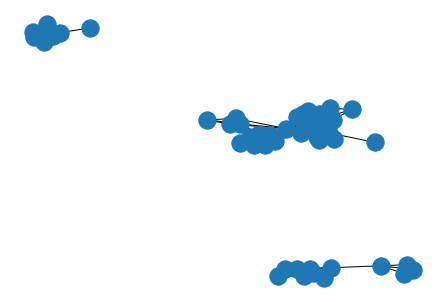

<Figure size 432x288 with 0 Axes>

In [29]:
#Plots a graph of each edge and node to display a visual of all connected components
G = nx.Graph()
for e in edges:
  G.add_edge(e[0],e[1])
nx.draw(G)
plt.show()
plt.clf()

In [45]:
#Finds the number of connected components
num_connect = len(list(nx.connected_components(G)))

#Finds the number of nodes in the largest connected component
num_nodes = len(max(list(nx.connected_components(G))))

In [46]:
{'Connected Components': num_connect,'Nodes In Largest Connected Component': num_nodes}

{'Connected Components': 3, 'Nodes In Largest Connected Component': 40}

# Problem 7
# Complete

In [43]:
#Sorts a list of all the node ID in the largest connected component
largest = sorted(list(max(list(nx.connected_components(G)))))

#Splits nodes in largest connected component between small and large ID
lowID = largest[:len(largest)//2]
highID = largest[len(largest)//2:]

In [47]:
#Calculates the normalized cut of the small and large ID values split early
#Since the built in networkx normalized cut function is used I needed to divide the answer by two to represent
#the 1/|C| constant that is multiplied in the normalized cut function shown in class
#C is two in this case because there are two communities caused by the cut of the nodes in the largest connected
#component into small and large ID
#The built in networkx normalized cut function does not multiply its result by the 1/|C| constant multiplier
#because it is meant to be used for directed graphs, but the graph here is undirected
nx.normalized_cut_size(G,lowID,highID)/2

0.4224058769513316

# Problem 8

In [48]:
def normalized_cut(G,S,T,weight=None):
    e = nx.edge_boundary(G,S,T,data=weight,default=1)
    nce = sum(weight for u,v,weight in e)
    vs = sum(d for v,d in G.degree(S,weight=weight))
    vt = sum(d for v,d in G.degree(T, weight=weight))
    return (1/2)*nce*((1/vs)+(1/vt))

In [63]:
first_loop = False
second_loop = False
cut_cost = 0
curr_cost = 1
num = 0
low = lowID.copy()
high = highID.copy()
while cut_cost < curr_cost:
    change = False
    for x in low:
        lowTemp = low.copy()
        highTemp = high.copy()
        highTemp.append(lowTemp.remove(x))
        curr_cost = nx.normalized_cut_size(G,lowTemp,highTemp)/2
        #curr_cost = normalized_cut(G,lowTemp,highTemp)
        if curr_cost < cut_cost:
            cut_cost = curr_cost
            num = x
            first_loop = True
            second_loop = False
            change = True
    for x in high:
        lowTemp = low.copy()
        highTemp = high.copy()
        lowTemp.append(highTemp.remove(x))
        curr_cost = nx.normalized_cut_size(G,lowTemp,highTemp)/2
        #curr_cost = normalized_cut(G,lowTemp,highTemp)
        if curr_cost < cut_cost:
            cut_cost = curr_cost
            num = x
            first_loop = False
            second_loop = True
            change = True
    if change == True:
        if first_loop == True:
            high.append(low.remove(num))
        else:
            low.append(high.remove(num))

KeyboardInterrupt: 

In [13]:
### Find all 3 and 4-cliques in the graph ###
cliques3 = set()
cliques4 = set()
for n1 in nodes:
  for n2 in nodes:
    if not ((n1,n2) in edges): continue
    for n3 in nodes:
      if not ((n1,n3) in edges): continue
      if not ((n2,n3) in edges): continue
      clique = [n1,n2,n3]
      clique.sort()
      cliques3.add(tuple(clique))
      for n4 in nodes:
        if not ((n1,n4) in edges): continue
        if not ((n2,n4) in edges): continue
        if not ((n3,n4) in edges): continue
        clique = [n1,n2,n3,n4]
        clique.sort()
        cliques4.add(tuple(clique))